# Experiment: Neural Network

## Input:
- Image data set from MNIST (28x28 pixels-image of numbers from 0 to 9)

## Output:
- Learned weight
- Weight's plotted image
- Average value to observe the threshold

## Method:
Run the experiment with 3 different architecture of Neural Network: 1, 2, and 3 hidden layer, respectively, model 1, 2 and 3.

# Models

## Model 1:
- input(784) -> output(10) -> softmax.
- Gradient Descent, $\eta = 0.5$, Cross-Entropy  

## Model 2:
- input(784) -> hidden layer(100) -> sigmoid -> output(10) -> softmax
- Gradient Descent, $\eta = 0.5$, Cross-Entropy  

## Model 3:
- input(784) -> hidden layer(100) -> sigmoid -> hidden layer(50) -> sigmoid-> output(10) -> softmax
- Gradient Descent, $\eta = 0.5$, Cross-Entropy  


In [1]:
'''TODO
- 3 models
'''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.datasets import fetch_mldata

import tensorflow as tf

import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from sklearn.pipeline import make_pipeline
import tensorflow.contrib.slim as slim
import math
import lime
from lime import lime_text
from lime import lime_image
import time

import random

In [2]:
def plot_weight_1(weight):
    plt.figure()
    plt.title(title)
    nmb_plotted_image = weight.shape[1]
    tmp = np.swapaxes(weight, 0, 1); plotted_images = []
    for i in tmp:
        image = np.reshape(i, (-1, 28))
        plotted_images.append(image)
    
    # plot
    fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
    fig_montage = montage2d(np.array(plotted_images), rescale_intensity = True)
    ax1.imshow(fig_montage, cmap='gray', interpolation = 'none')
    ax1.set_title('Weight')
    ax1.axis('off')
    
def plot_weight_2(weight):
    nmb_plotted_image = weight.shape[1]
    tmp = np.swapaxes(weight, 0, 1); plotted_images = []
    for i in tmp:
        image = np.reshape(i, (-1, 28))
        plotted_images.append(image)
    
    # plot
    fig = plt.figure(1, figsize=(20,20))
    n_columns = 10
    n_rows = math.ceil(nmb_plotted_image / n_columns) + 1
    for i in range(nmb_plotted_image):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Weight ' + str(i))
        plt.imshow(plotted_images[i], interpolation="nearest", cmap="gray")
    plt.colorbar()

def plot_weight_3(weight, n_reshape, is_weight = True):
    nmb_plotted_image = weight.shape[1]
    tmp = np.swapaxes(weight, 0, 1); plotted_images = []
    for i in tmp:
        image = np.reshape(i, (-1, n_reshape))
        plotted_images.append(image)
    
    # plot
    fig = plt.figure(1, figsize=(20,20))
    n_columns = 10
    n_rows = math.ceil(nmb_plotted_image / n_columns) + 1
    for i in range(nmb_plotted_image):
        plt.subplot(n_rows, n_columns, i+1)
        if (is_weight == True):
            plt.title('Weight ' + str(i))
        else:
            plt.title('Layer')
        plt.imshow(plotted_images[i], interpolation="nearest", cmap="plasma")
    plt.colorbar()
    plt.show()
    
def plot_positive_negative_region(mask, temp, label, image, explanation):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(np.argmax(label)))
    temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(np.argmax(label)))
    plt.show()
    # show them for each class
    fig, m_axs = plt.subplots(2,5, figsize = (12,6))
    for i, c_ax in enumerate(m_axs.flatten()):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
        c_ax.imshow(label2rgb(mask,image, bg_label = 0), interpolation = 'nearest')
        c_ax.set_title('Positive for {}\nActual {}'.format(i, np.argmax(label)))
        c_ax.axis('off')
    plt.show()

In [3]:
def model_1(iteration, plot_technique, influence_technique):
    # Import data
    mnist = input_data.read_data_sets('MNIST_data/', one_hot= True)
    
    # Create the model
    x = tf.placeholder(tf.float32, [None, 28, 28, 3], name = 'x-in')
    tmp_x_01 = tf.reshape(x, [-1, 784, 3])
    processed_x = tf.image.rgb_to_grayscale(tmp_x_01)[:,:,0]
    W = tf.Variable(tf.random_normal([784, 10]), name='W')
    b = tf.Variable(tf.random_normal([10]), name='b')
    y = tf.matmul(processed_x, W) + b
    prediction = tf.nn.softmax(y)
    # Define loss and optimizer
    true_y = tf.placeholder(tf.float32, [None, 10], name = 'y-in')
    cross_entropy = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(labels=true_y, logits=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    sess = tf.InteractiveSession()   
    tf.global_variables_initializer().run()

    # Train
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(true_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    for i in range(iteration):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        batch_xs = np.stack([gray2rgb(iimg) for iimg in batch_xs.reshape((-1, 28, 28))], 0)
        sess.run(train_step, feed_dict={x: batch_xs, true_y: batch_ys})
        if (i%1000 == 0 and i != 0):
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, true_y:batch_ys})
            print ('step %d, training accuracy %g' %(i, train_accuracy))
    # Test trained model
    print ('Accuracy', sess.run(accuracy, feed_dict={x: np.stack([gray2rgb(iimg) for iimg in mnist.test.images.reshape((-1, 28, 28))], 0), 
                                         true_y: mnist.test.labels}))
    # Plot the weight
    index = random.randint(0, mnist.test.images.shape[0])
    image = np.array([mnist.test.images[index]])
    label = mnist.test.labels[index]
    
    plotted_W = sess.run(W, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W, 28)
    prediction = sess.run(prediction, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(np.swapaxes(prediction, 0, 1), 10, False)
    # Calculate mean
    mean_weight = np.mean(plotted_W)
    print ('Mean weight', mean_weight, ' Max weight', np.max(plotted_W), ' Min weight', np.min(plotted_W))
    
    # Using explainer
    if (influence_technique == 'lime'):
        class_names = [str(i) for i in range(0, 10)]
        explainer = lime_image.LimeImageExplainer()
        
        def predict_fn(images):
            probabilities = tf.nn.softmax(tf.matmul(processed_x, W) + b)
            return sess.run(probabilities, feed_dict = {x:images})
        
        print('Top 5 prediction')
        preds = predict_fn(gray2rgb(np.reshape(image, [-1, 28, 28])))
        for prediction in preds.argsort()[0][-5:][::-1]:
            print (prediction, preds[0, prediction])
        plt.figure()
        
        plt.title('Sample image')
        imgplot = plt.imshow(np.reshape(image[0], (-1, 28)), cmap = 'gray')
        plt.show()
        
        tmp = time.time()
        
        # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
        explanation = explainer.explain_instance(gray2rgb(np.reshape(image, [-1, 28, 28]))[0], 
                                                 predict_fn, top_labels=10, hide_color=0, num_samples=1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(image, [-1, 28, 28]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)
    sess.close()

In [4]:
def model_2(iteration, plot_technique, influence_technique):
    # Import data
    mnist = input_data.read_data_sets('MNIST_data/', one_hot= True)
    
    # Create the model
    x = tf.placeholder(tf.float32, [None, 28, 28, 3], name = 'x-in')
    tmp_x_01 = tf.reshape(x, [-1, 784, 3])
    processed_x = tf.image.rgb_to_grayscale(tmp_x_01)[:,:,0]
    
    hidden_layer_check = tf.placeholder(tf.float32, [None, 10, 10, 3], name = 'hidden_layer_check')    
    processed_hidden = tf.reshape(hidden_layer_check, [-1, 100, 3])
    processed_hidden = tf.image.rgb_to_grayscale(processed_hidden)[:,:,0]
    W1 = tf.Variable(tf.random_normal([784, 100]), name='W1')
    b1 = tf.Variable(tf.random_normal([100]), name='b1')
    o1 = tf.nn.sigmoid(tf.matmul(processed_x, W1) + b1)
    
    W2 = tf.Variable(tf.random_normal([100, 10]), name='W2')
    b2 = tf.Variable(tf.random_normal([10]), name='b2')
    y = tf.matmul(o1, W2) + b2
    y_check = tf.matmul(processed_hidden, W2) + b2
    
    # Define loss and optimizer
    true_y = tf.placeholder(tf.float32, [None, 10], name = 'y-in')
    cross_entropy = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(labels=true_y, logits=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    sess = tf.InteractiveSession()   
    tf.global_variables_initializer().run()

    # Train
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(true_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    for i in range(iteration):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        batch_xs = np.stack([gray2rgb(iimg) for iimg in batch_xs.reshape((-1, 28, 28))], 0)
        sess.run(train_step, feed_dict={x: batch_xs, true_y: batch_ys})
        if (i%1000 == 0 and i != 0):
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, true_y:batch_ys})
            print ('step %d, training accuracy %g' %(i, train_accuracy))
    # Test trained model
    print ('Accuracy', sess.run(accuracy, feed_dict={x: np.stack([gray2rgb(iimg) for iimg in mnist.test.images.reshape((-1, 28, 28))], 0), 
                                         true_y: mnist.test.labels}))
    # Plot the weight
    index = random.randint(0, mnist.test.images.shape[0])
    image = np.array([mnist.test.images[index]])
    label = mnist.test.labels[index]
  
    print ('Weight')
    plotted_W1 = sess.run(W1, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W1, 28)
    plotted_W2 = sess.run(W2, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W2, 10)
    
    print ('Layer')
    plotted_o1 = sess.run(o1, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(np.swapaxes(plotted_o1, 0, 1), 10, False)
    # Calculate mean
    mean_weight_W1 = np.mean(plotted_W1)
    print ('Mean weight W1', mean_weight_W1, ' Max weight', np.max(plotted_W1), ' Min weight', np.min(plotted_W1))
    mean_weight_W2 = np.mean(plotted_W2)
    print ('Mean weight W2', mean_weight_W2, ' Max weight', np.max(plotted_W2), ' Min weight', np.min(plotted_W2))
    mean_weight_o1 = np.mean(plotted_o1)
    print ('Mean layer L1', mean_weight_o1, ' Max layer', np.max(plotted_o1), ' Min layer', np.min(plotted_o1))
    
    
    # Using explainer
    if (influence_technique == 'lime'):
        class_names = [str(i) for i in range(0, 10)]
        explainer = lime_image.LimeImageExplainer()
        
        def predict_fn(images):
            probabilities = tf.nn.softmax(y)
            return sess.run(probabilities, feed_dict = {x:images})
        def predict_fn2(images):
            return sess.run(y_check, feed_dict = {hidden_layer_check:images})
    
        print('Top 5 prediction')
        preds = predict_fn(gray2rgb(np.reshape(image, [-1, 28, 28])))
        for prediction in preds.argsort()[0][-5:][::-1]:
            print (prediction, preds[0, prediction])
        plt.figure()
        
        
        plt.title('Sample image')
        imgplot = plt.imshow(np.reshape(image[0], (-1, 28)), cmap = 'gray')
        plt.show()
        tmp = time.time()
        
        # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
        hidden = sess.run(o1, feed_dict={x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
        hidden = np.reshape(hidden, [10, 10])
        
        explanation = explainer.explain_instance(gray2rgb(hidden), predict_fn2, top_labels =10, hide_color = 0, num_samples=1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(hidden, [-1, 10, 10]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)

        explanation = explainer.explain_instance(gray2rgb(np.reshape(image, [-1, 28, 28]))[0], 
                                                 predict_fn, top_labels=10, hide_color=0, num_samples=1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(image, [-1, 28, 28]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)
        
    sess.close()

In [5]:
def model_3(iteration, plot_technique, influence_technique):
    # Import data
    mnist = input_data.read_data_sets('MNIST_data/', one_hot= True)
    
    # Create the model
    x = tf.placeholder(tf.float32, [None, 28, 28, 3], name = 'x-in')
    tmp_x_01 = tf.reshape(x, [-1, 784, 3])
    processed_x = tf.image.rgb_to_grayscale(tmp_x_01)[:,:,0]
    
    W1 = tf.Variable(tf.random_normal([784, 100]), name='W1')
    b1 = tf.Variable(tf.random_normal([100]), name='b1')
    o1 = tf.nn.sigmoid(tf.matmul(processed_x, W1) + b1)
  
    W2 = tf.Variable(tf.random_normal([100, 49]), name='W2')
    b2 = tf.Variable(tf.random_normal([49]), name='b2')
    o2 = tf.nn.sigmoid(tf.matmul(o1, W2) + b2)
    
    W3 = tf.Variable(tf.random_normal([49, 10]), name='W3')
    b3 = tf.Variable(tf.random_normal([10]), name='b3')
    y = tf.matmul(o2, W3) + b3
    
          
    # Define loss and optimizer
    true_y = tf.placeholder(tf.float32, [None, 10], name = 'y-in')
    cross_entropy = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(labels=true_y, logits=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    sess = tf.InteractiveSession()   
    tf.global_variables_initializer().run()

    # Train
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(true_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    for i in range(iteration):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        batch_xs = np.stack([gray2rgb(iimg) for iimg in batch_xs.reshape((-1, 28, 28))], 0)
        sess.run(train_step, feed_dict={x: batch_xs, true_y: batch_ys})
        if (i%1000 == 0 and i != 0):
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, true_y:batch_ys})
            print ('step %d, training accuracy %g' %(i, train_accuracy))
    # Test trained model
    print ('Accuracy', sess.run(accuracy, feed_dict={x: np.stack([gray2rgb(iimg) for iimg in mnist.test.images.reshape((-1, 28, 28))], 0), 
                                         true_y: mnist.test.labels}))
    # Plot the weight
    index = random.randint(0, mnist.test.images.shape[0])
    image = np.array([mnist.test.images[index]])
    label = mnist.test.labels[index]
   
    print ('Weight')
    plotted_W1 = sess.run(W1, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W1, 28)
    plotted_W2 = sess.run(W2, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W2, 10)
    plotted_W3 = sess.run(W3, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(plotted_W3, 7)
    
    print ('Layer')
    plotted_o1 = sess.run(o1, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(np.swapaxes(plotted_o1, 0, 1), 10, False)
    plotted_o2 = sess.run(o2, feed_dict = {x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
    plot_technique(np.swapaxes(plotted_o2, 0, 1), 7, False)

    # Calculate mean
    mean_weight_W1 = np.mean(plotted_W1)
    print ('Mean weight W1', mean_weight_W1, ' Max weight', np.max(plotted_W1), ' Min weight', np.min(plotted_W1))
    mean_weight_W2 = np.mean(plotted_W2)
    print ('Mean weight W2', mean_weight_W2, ' Max weight', np.max(plotted_W2), ' Min weight', np.min(plotted_W2))
    mean_weight_W3 = np.mean(plotted_W3)
    print ('Mean weight W3', mean_weight_W3, ' Max weight', np.max(plotted_W3), ' Min weight', np.min(plotted_W3))
    mean_weight_o1 = np.mean(plotted_o1)
    print ('Mean layer L1', mean_weight_o1, ' Max layer', np.max(plotted_o1), ' Min layer', np.min(plotted_o1))
    mean_weight_o2 = np.mean(plotted_o2)
    print ('Mean layer L2', mean_weight_o2, ' Max layer', np.max(plotted_o2), ' Min layer', np.min(plotted_o2))
    
    
    # Using explainer
    if (influence_technique == 'lime'):
        class_names = [str(i) for i in range(0, 10)]
        explainer = lime_image.LimeImageExplainer()
        
        def predict_fn(images):
            probabilities = tf.nn.softmax(y)
            return sess.run(probabilities, feed_dict = {x:images})
        def predict_fn_1(layer01):
            hidden_01 = tf.placeholder(tf.float32, [None, 10, 10, 3], name = 'hidden_layer_check')    
            processed_hidden_01 = tf.reshape(hidden_01, [-1, 100, 3])
            processed_hidden_01 = tf.image.rgb_to_grayscale(processed_hidden_01)[:,:,0]
            
            y_01 = tf.nn.sigmoid(tf.matmul(processed_hidden_01, W2)+b2)
            y_02 = tf.nn.softmax(tf.matmul(y_01, W3)+b3)
            return sess.run(y_02, feed_dict = {hidden_01:layer01})
        def predict_fn_2(layer_02):
            hidden_02 = tf.placeholder(tf.float32, [None, 7, 7, 3])
            processed_hidden_02 = tf.reshape(hidden_02, [-1, 49, 3])
            processed_hidden_02 = tf.image.rgb_to_grayscale(processed_hidden_02)[:,:, 0]
            
            y_03 = tf.nn.softmax(tf.matmul(processed_hidden_02, W3)+b3)
            return sess.run(y_03, feed_dict = {hidden_02:layer_02})
        print('Top 5 prediction')
        preds = predict_fn(gray2rgb(np.reshape(image, [-1, 28, 28])))
        for prediction in preds.argsort()[0][-5:][::-1]:
            print (prediction, preds[0, prediction])
        plt.figure()
        
        plt.title('Sample image')
        imgplot = plt.imshow(np.reshape(image[0], (-1, 28)), cmap = 'gray')
        plt.show()
        
        tmp = time.time()
        
        # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
       
        hidden = sess.run(o1, feed_dict={x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
        hidden = np.reshape(hidden, [10, 10])
        
        explanation = explainer.explain_instance(gray2rgb(hidden), predict_fn_1, top_labels =10, hide_color = 0, num_samples=1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(hidden, [-1, 10, 10]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)
        
        hidden = sess.run(o2, feed_dict={x:gray2rgb(np.reshape(image, [-1, 28, 28]))})
        hidden = np.reshape(hidden, [7, 7])
        
        explanation = explainer.explain_instance(gray2rgb(hidden), predict_fn_2, top_labels = 10, hide_color = 0, num_samples =1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(hidden, [-1, 7, 7]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)
        
        explanation = explainer.explain_instance(gray2rgb(np.reshape(image, [-1, 28, 28]))[0], 
                                                 predict_fn, top_labels=10, hide_color=0, num_samples=1000)
        print ('Estimated time:', time.time() - tmp)
        temp, mask = explanation.get_image_and_mask(np.argmax(label), positive_only=True, num_features=10, hide_rest=True)
        sample_img = gray2rgb(np.reshape(image, [-1, 28, 28]))[0]
        plot_positive_negative_region(mask, temp, label, sample_img, explanation)
        
    sess.close()

# Experiment section

## Data:
MNIST is dataset consisting of images of 10 different numbers from 0 to 9. The task is classification.
## For each model, the following data are shown:
- Accuracy after every training steps
- Accuracy on test set
- Mean, max, and min value of weight and layer, one by one
- Top 5 prediction along with their probabilities
- Plotted graph of weight and layer
- Sample image
- LIME representation: the pink region is where the ground truth label contributes to the prediction



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 1000, training accuracy 0.94
Accuracy 0.8912


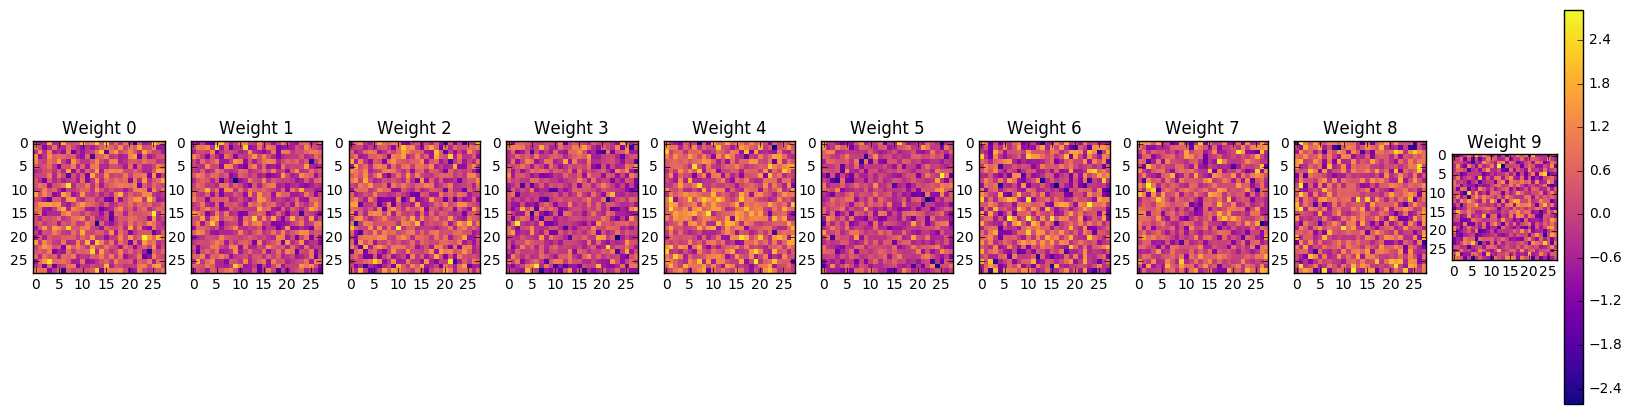

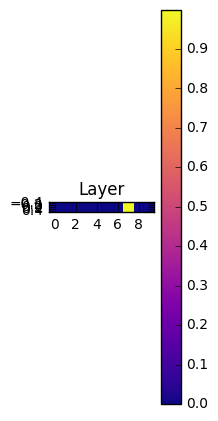

Mean weight 0.0150032  Max weight 3.71755  Min weight -3.5212
Top 5 prediction
7 0.999182
9 0.000811073
4 7.41089e-06
8 4.13336e-08
5 5.45063e-09


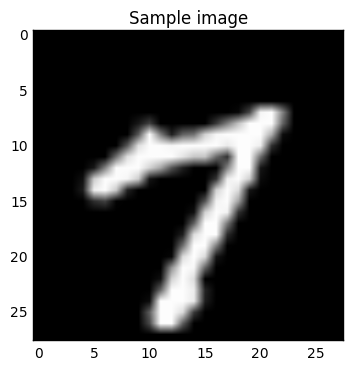

Estimated time: 8.691234350204468


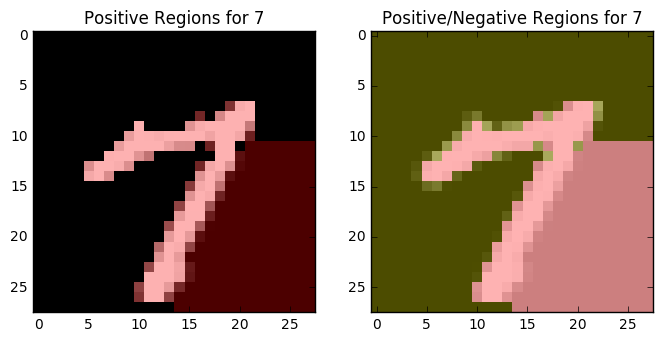

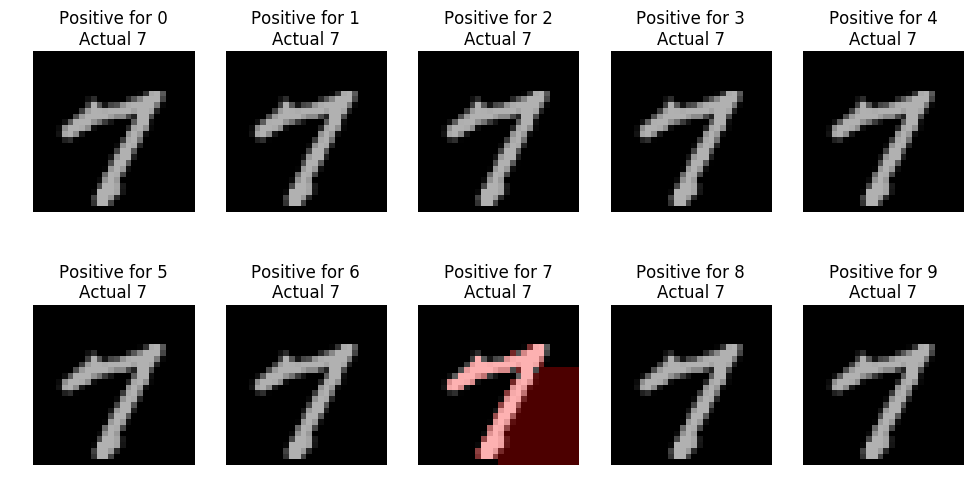

In [7]:
random.seed(40)

# plot_weight_1: grayscale in 1 figure
# plot_weight_2: grayscale in multiple sub figures
# plot_weight_3: color in multiple sub figures
iteration = 2000; plot_technique = plot_weight_3; influence_technique = 'lime'
model_1(iteration, plot_weight_3, influence_technique) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 1000, training accuracy 0.89
Accuracy 0.903
Weight


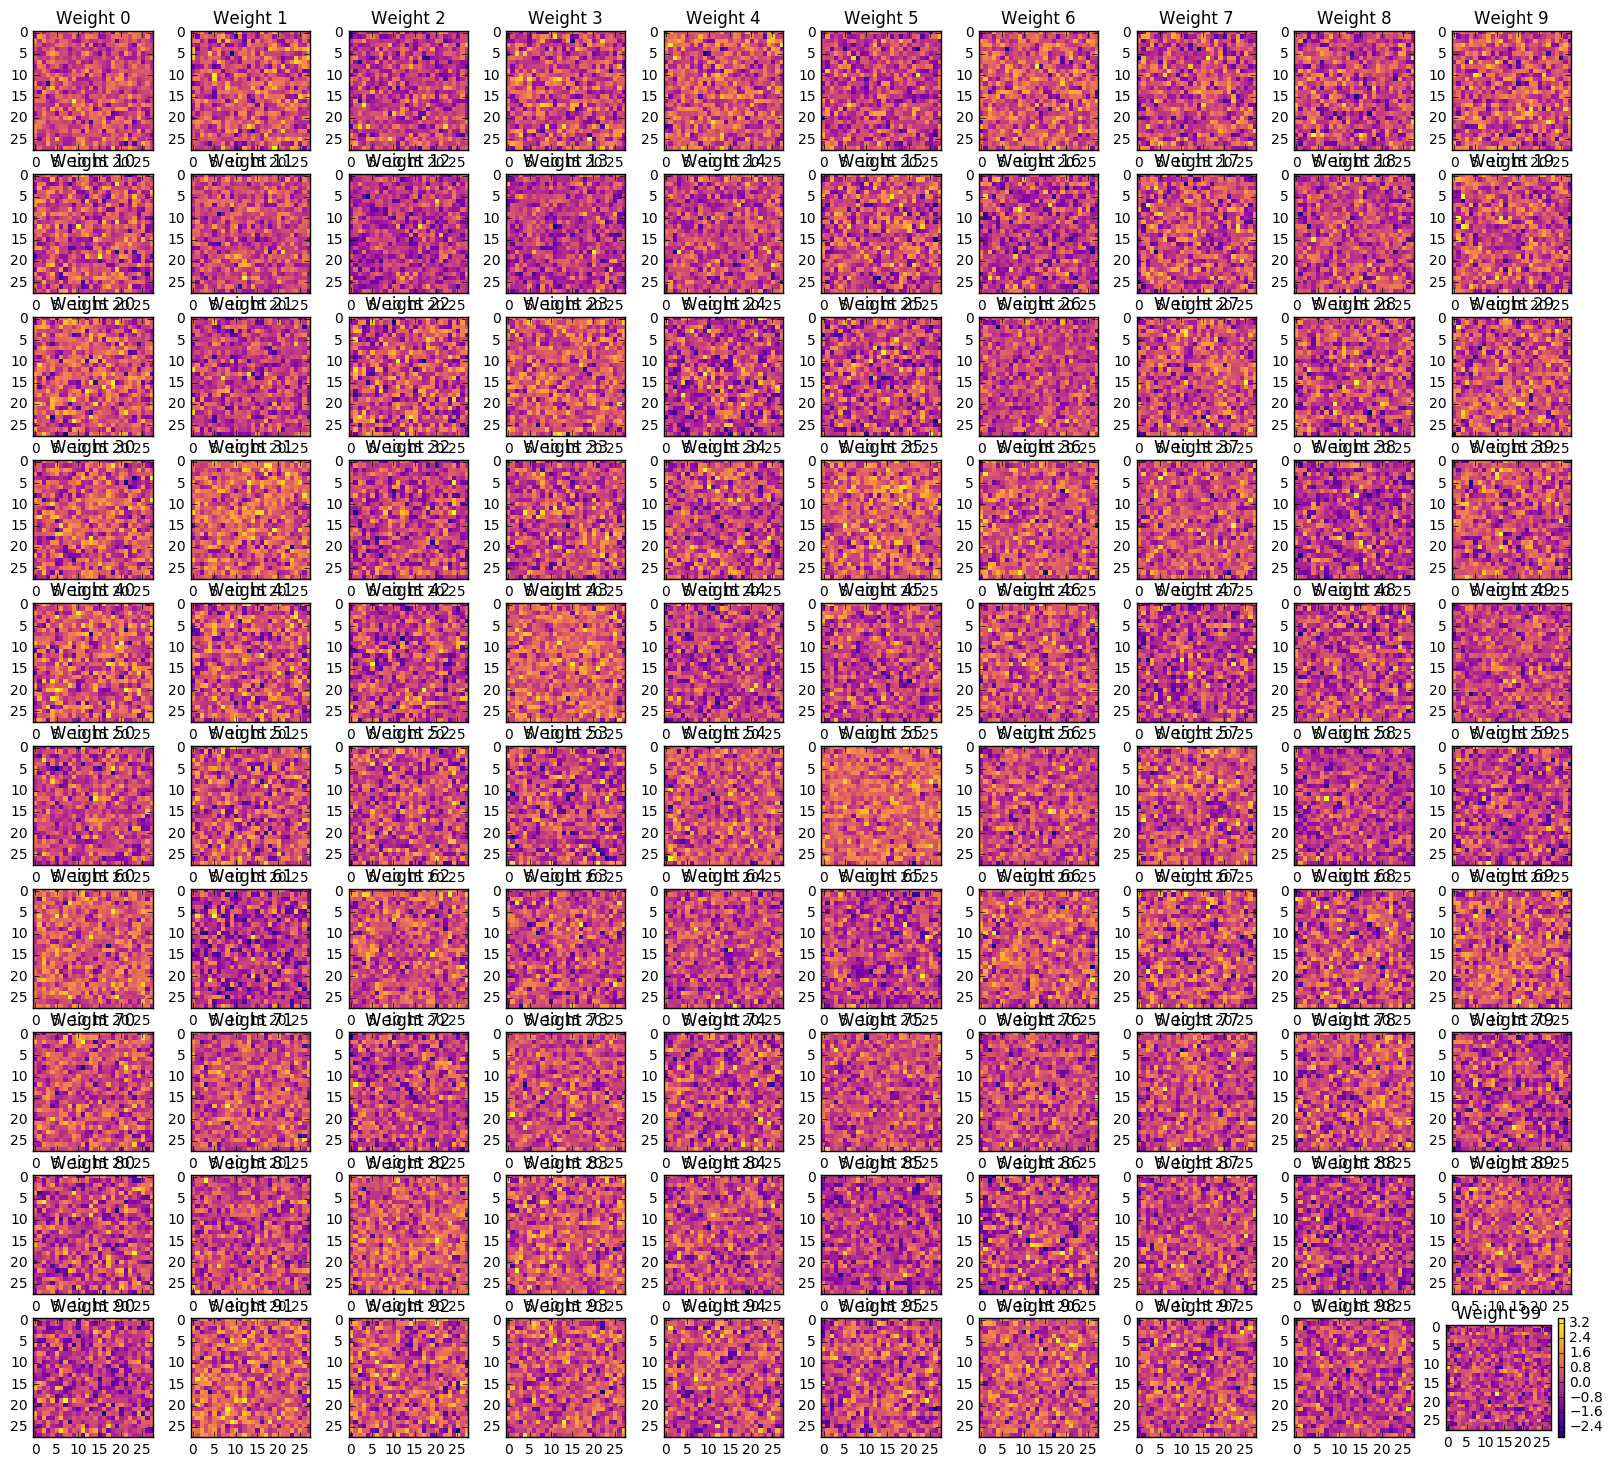

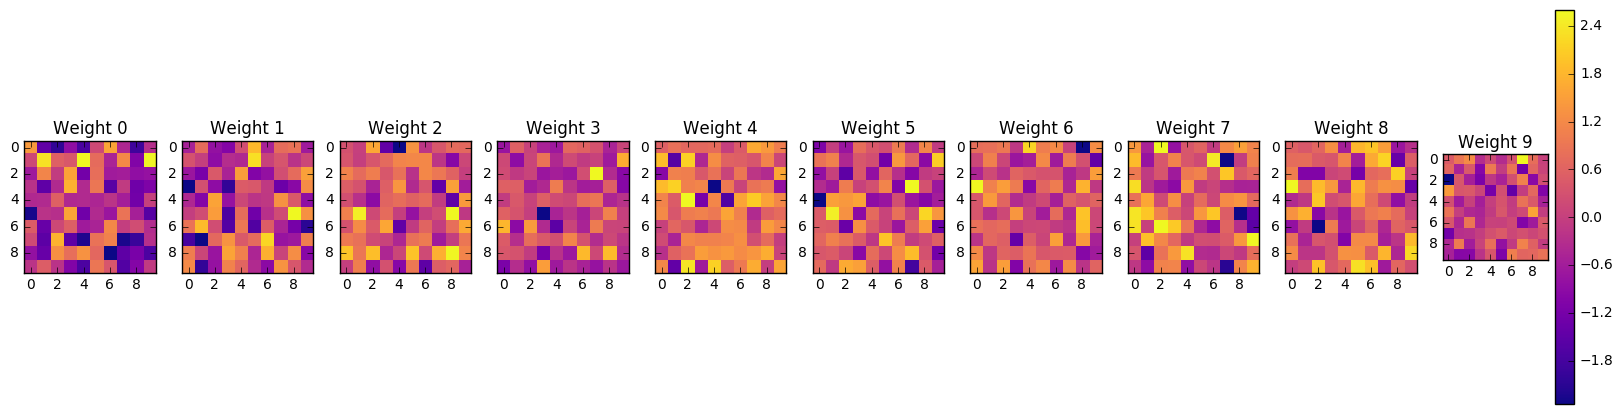

Layer


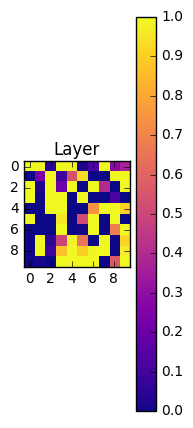

Mean weight W1 -0.00136928  Max weight 4.25268  Min weight -4.29762
Mean weight W2 0.0132274  Max weight 2.7055  Min weight -2.95302
Mean layer L1 0.517221  Max layer 1.0  Min layer 1.11989e-11
Top 5 prediction
9 0.773769
4 0.224372
7 0.00111752
8 0.000483323
5 0.000241691


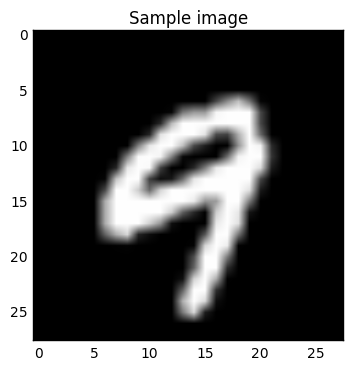

Estimated time: 0.1363534927368164


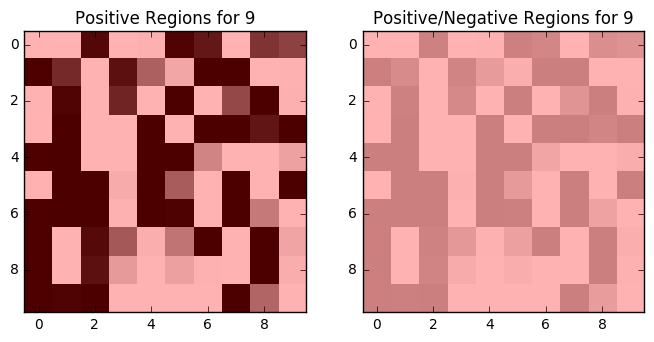

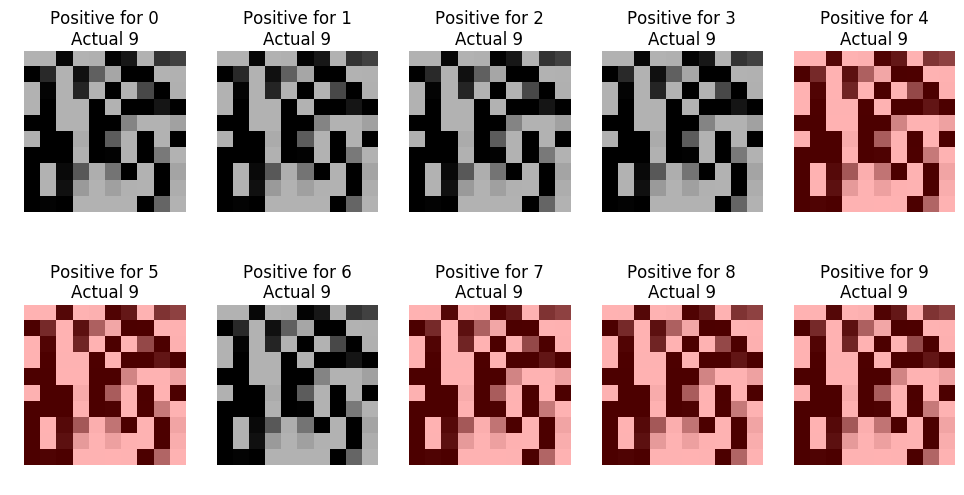

Estimated time: 9.883816957473755


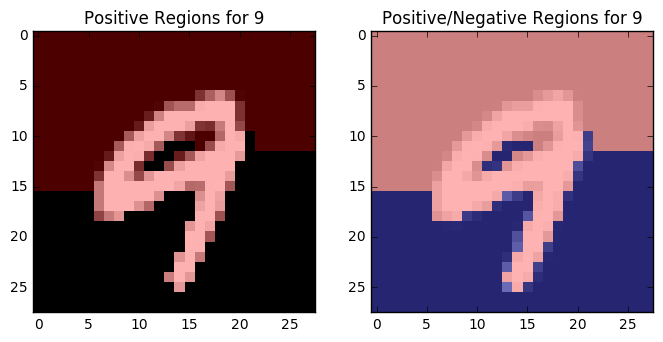

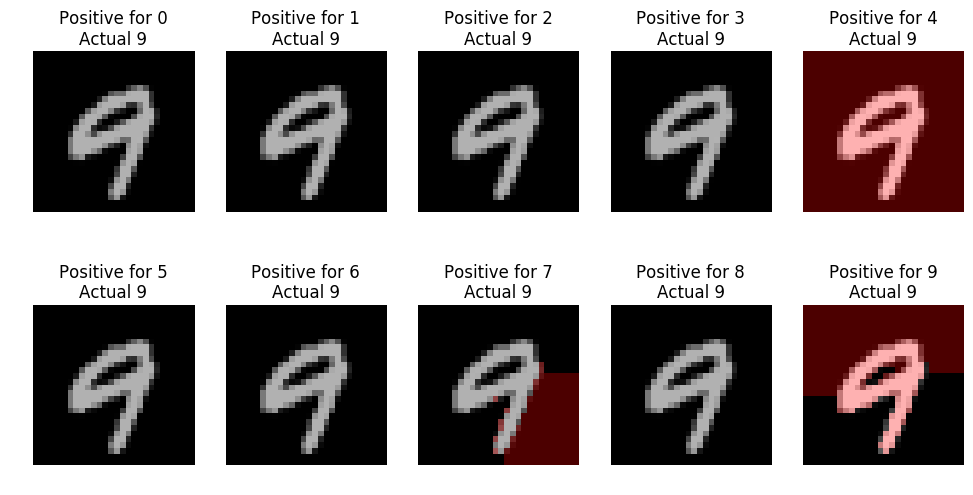

In [8]:
random.seed(20)
iteration = 2000; plot_technique = plot_weight_3; influence_technique = 'lime'
model_2(iteration, plot_weight_3, influence_technique) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 1000, training accuracy 0.93
Accuracy 0.8967
Weight


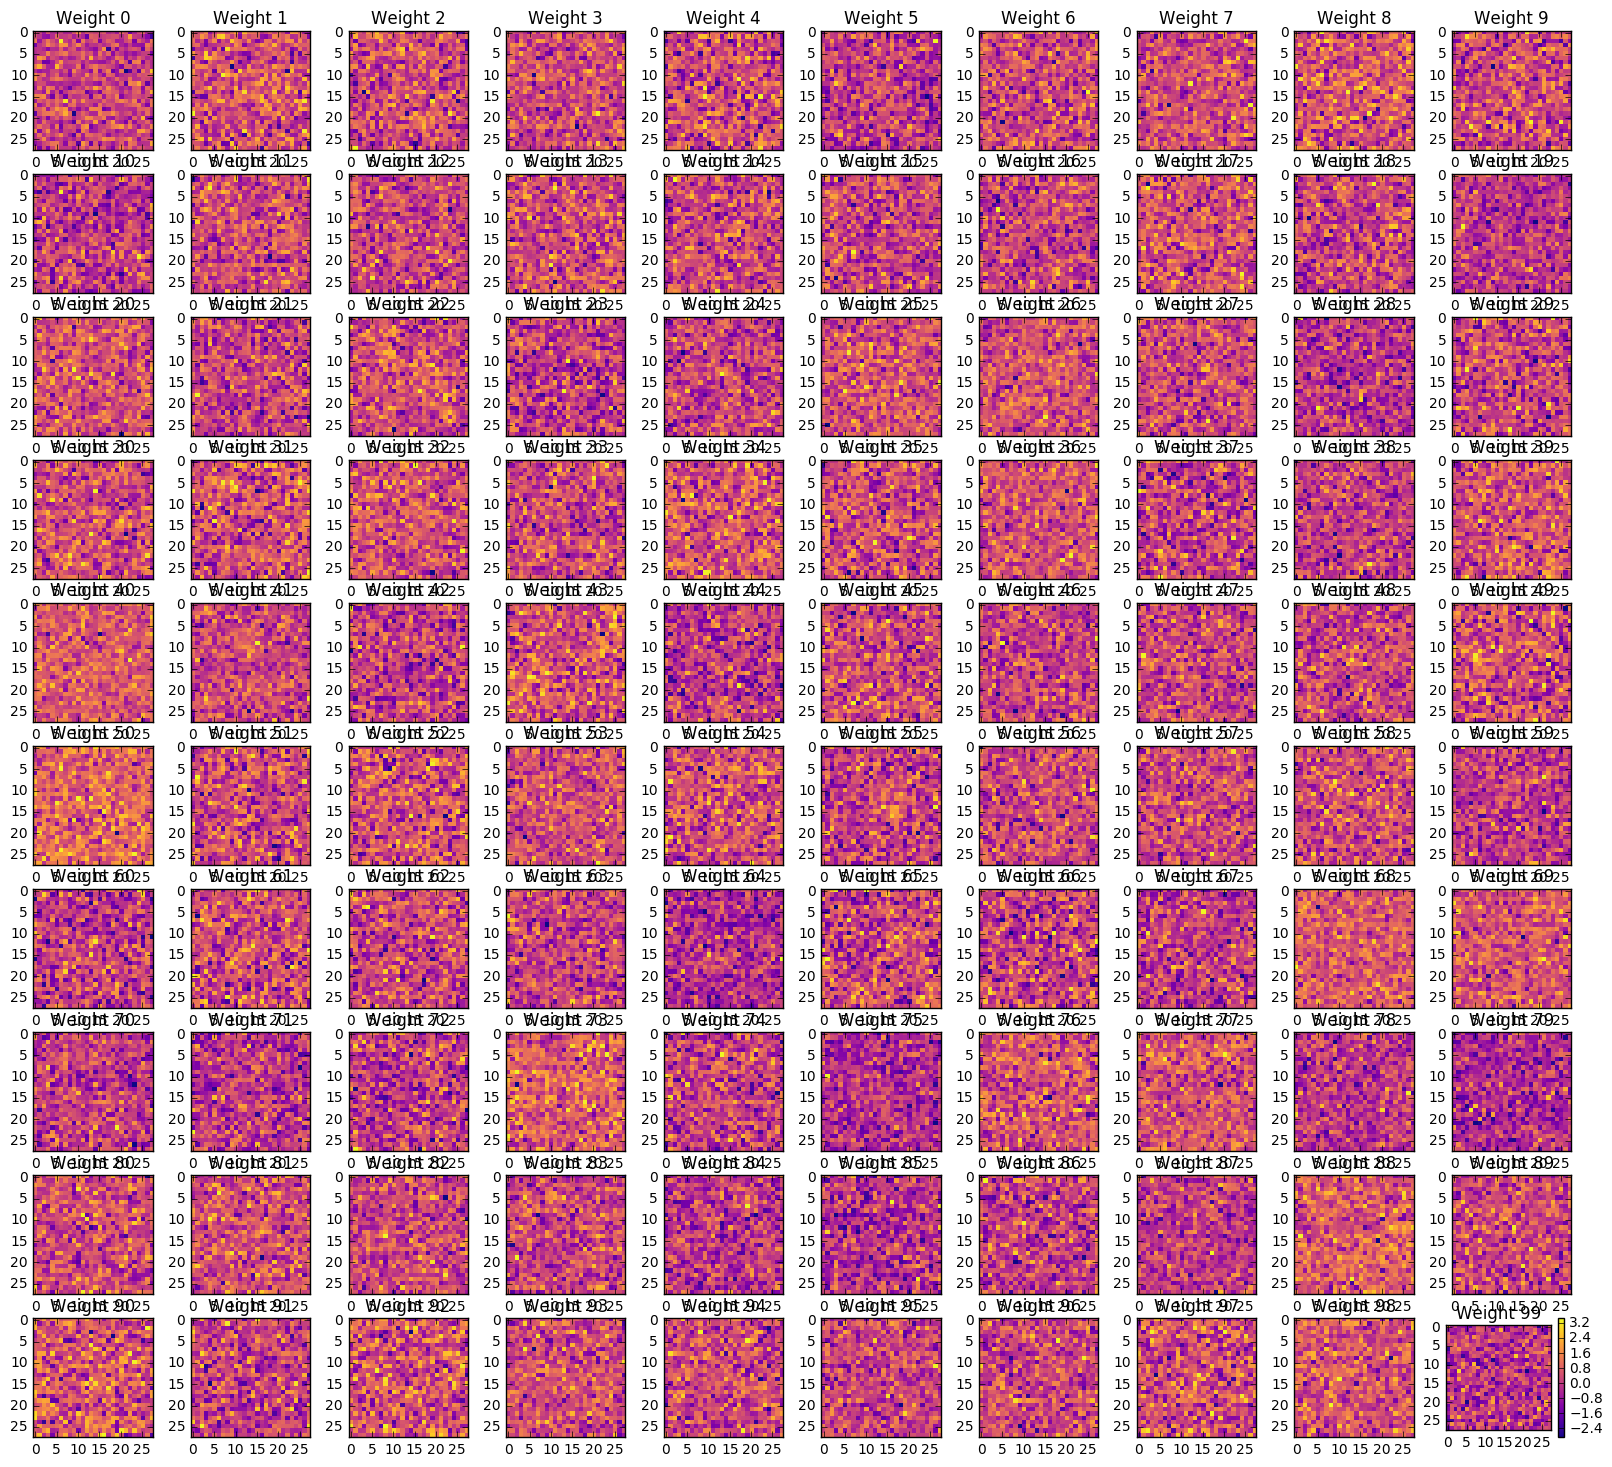

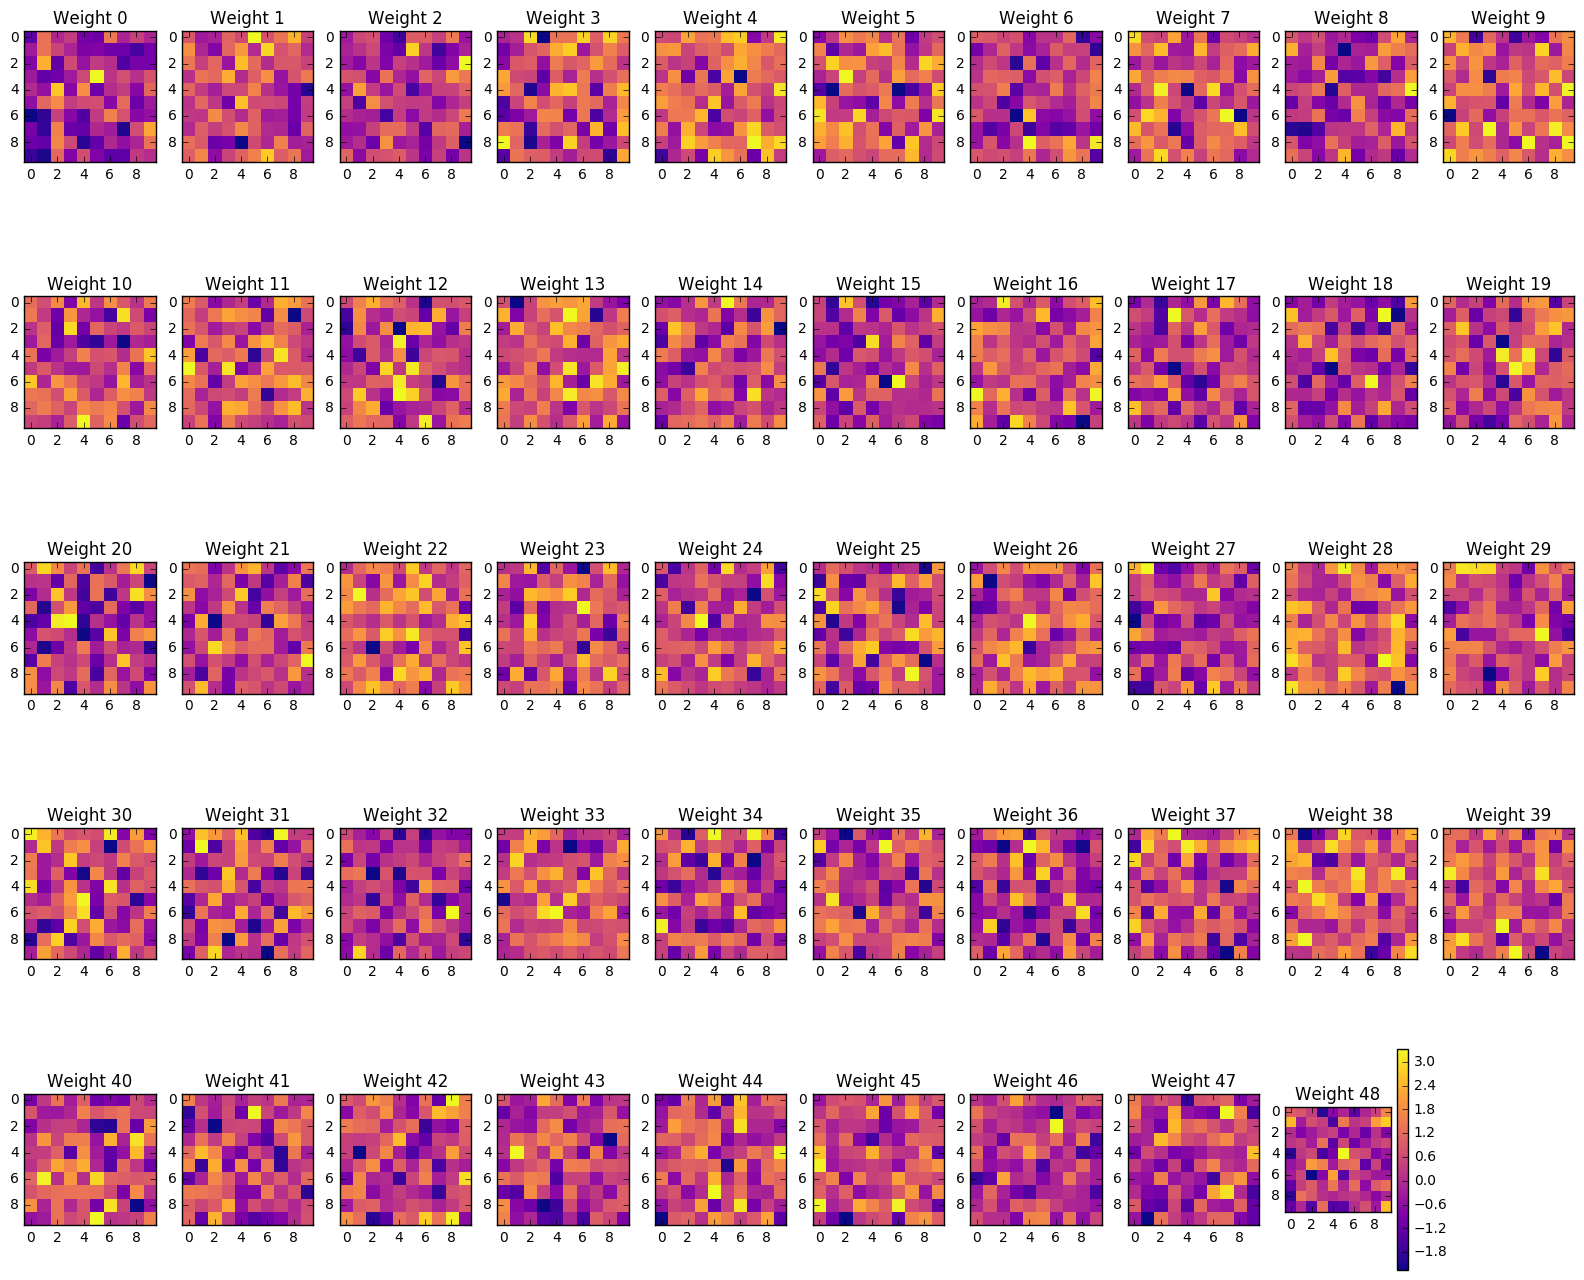

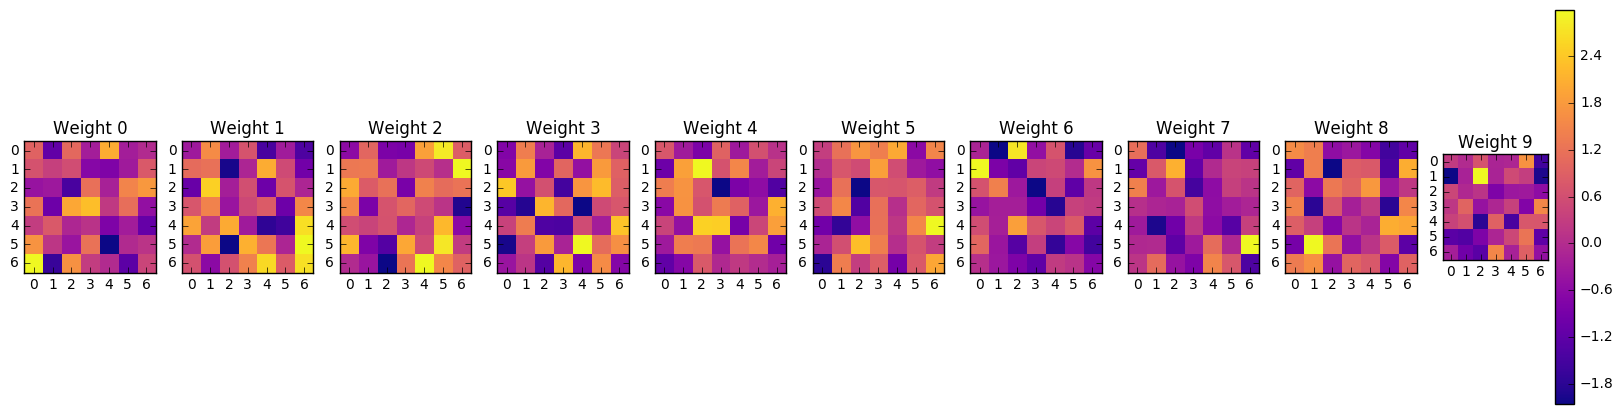

Layer


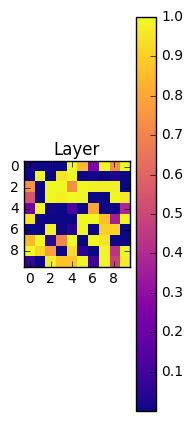

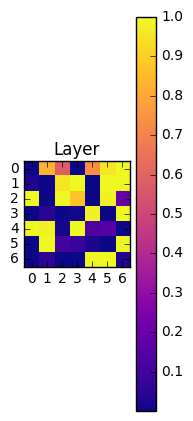

Mean weight W1 -0.000936273  Max weight 4.04852  Min weight -4.5201
Mean weight W2 -0.0116999  Max weight 3.44423  Min weight -3.15483
Mean weight W3 -0.0124919  Max weight 3.26012  Min weight -2.68454
Mean layer L1 0.514174  Max layer 1.0  Min layer 3.22917e-10
Mean layer L2 0.443697  Max layer 1.0  Min layer 2.03706e-09
Top 5 prediction
7 0.664165
9 0.207144
3 0.0900488
2 0.0356715
8 0.00111557


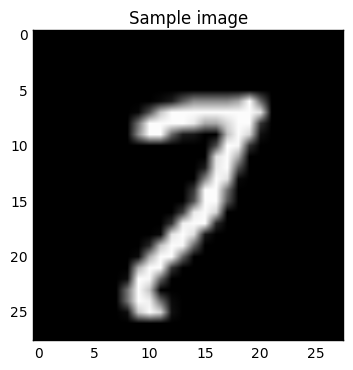

Estimated time: 14.175182342529297


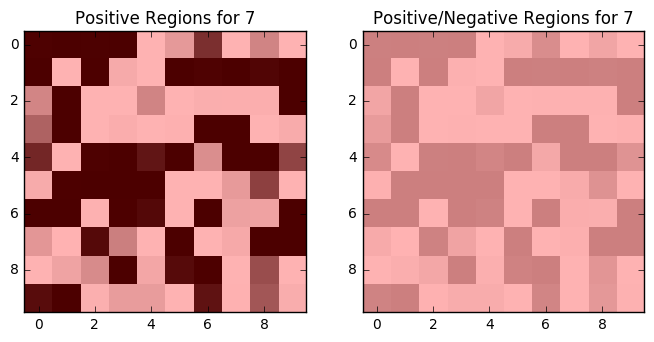

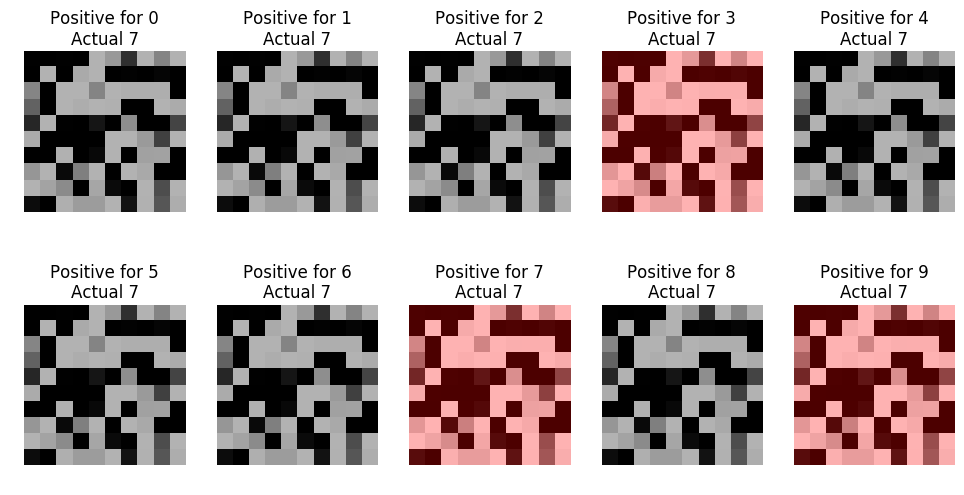

Estimated time: 31.92501139640808


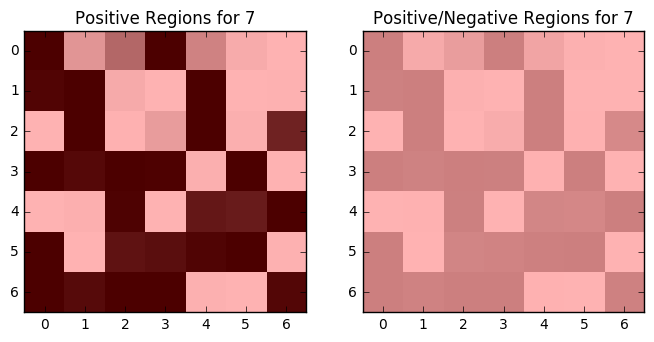

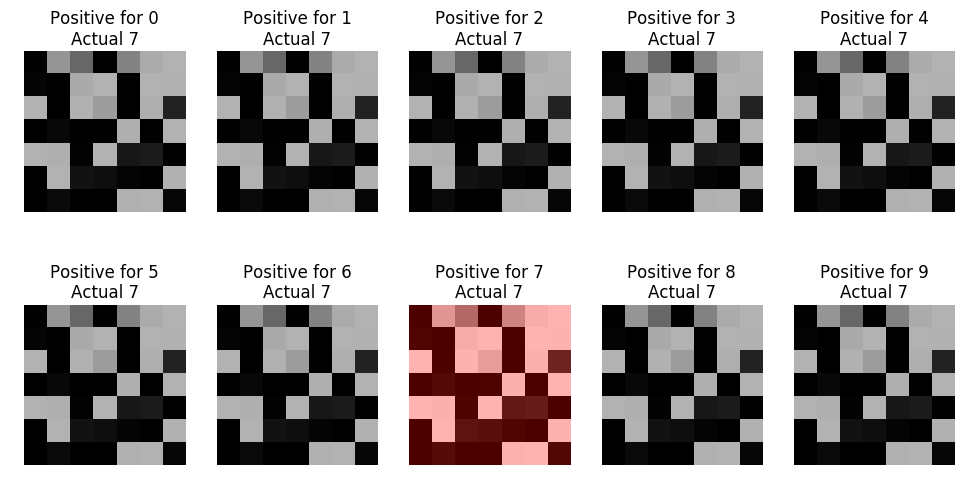

Estimated time: 50.040205001831055


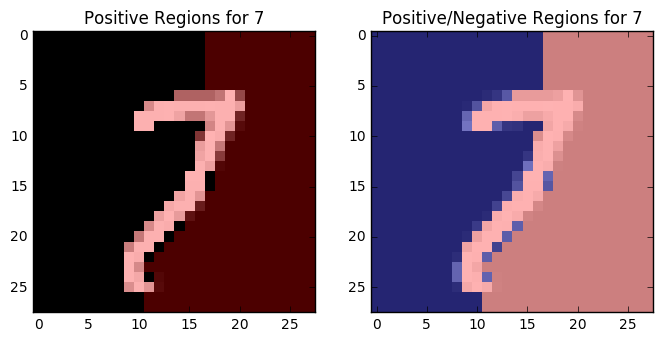

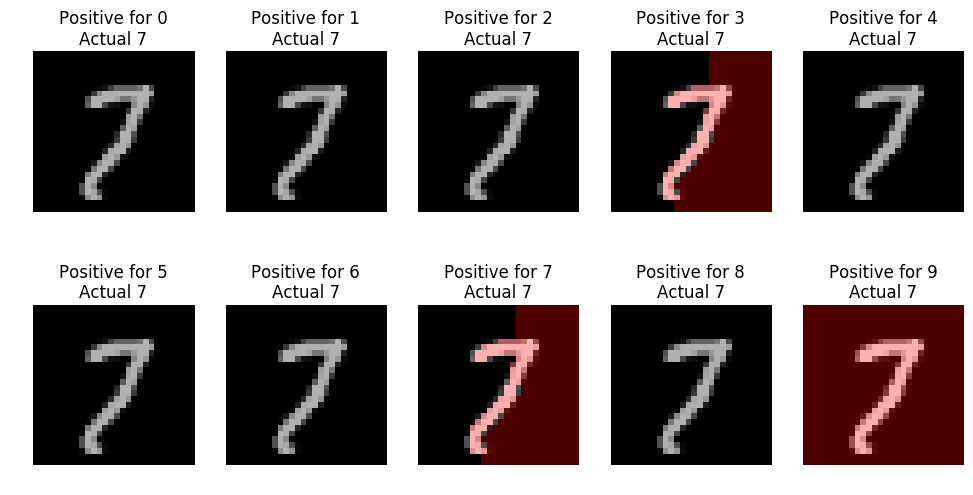

In [9]:
random.seed(50)
iteration = 2000; plot_technique = plot_weight_3; influence_technique = 'lime'
model_3(iteration, plot_weight_3, influence_technique) 